In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from trickdataset import TrickDataset
import numpy as np
from random import shuffle
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report, matthews_corrcoef
from torchmetrics import ConfusionMatrix
import seaborn as sn
import pandas as pd

### Setting hyperparams

In [46]:
# How often will the network be trained on the entire dataset
num_epochs = 30

# Batch size
batch_size = 15

# By how much the weights get updated
learning_rate = 0.0005

# 120 samples in x channels
input_size = 3

# Shuffle the dataset
shuffle_dataset = True
shuffle_seed = np.random.randint(45)

# How many parts of the dataset should be used for testing
test_split = 0.2

# Use LSTM instead of Convolutional model:
UseLSTM = False
if UseLSTM:
    num_hidden = 64
    num_layers = 3

### Loading Dataset

In [47]:

trick_list = ['0', '1', '2']
trickdataset = TrickDataset(rootfolder="golfdata", label_list=trick_list)

#  Get number of tricks the network will be trained on
num_samples = len(trickdataset)

# Get number of classes
num_classes = len(trick_list)

# Get number of training cycles per epoch
num_iterations = math.ceil(num_samples/batch_size)

# List of indices corresponding to each trick sample [0, 1, 2, .. n_tricks]
indices = list(range(num_samples))

if shuffle_dataset:
    np.random.seed(shuffle_seed)
    np.random.shuffle(indices)

# Index at which the dataset should be split in train and test parts
split_idx = int(np.floor(test_split * num_samples))

# Lists containing all indexes belonging to train and test parts
train_indices, test_indices = indices[split_idx:], indices[:split_idx]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Splitting dataset into train and test loaders 
train_loader = torch.utils.data.DataLoader(trickdataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(trickdataset, batch_size=batch_size, sampler=test_sampler)

golfdata ['0', '1', '2']


### Model definition

In [48]:
class tricknetCONV(nn.Module):
    def __init__(self, input_size, n_classes):
        super(tricknetCONV,self).__init__()

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # NN layers
        self.fc1 = nn.Linear(
            in_features=input_size,
            out_features=256
        )

        self.fc2 = nn.Linear(
            in_features=256,
            out_features=64
        )

        self.conv1 = nn.Conv1d(
            in_channels=64, 
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=1
            )

        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=1
            )

        self.fc3 = nn.Linear(
            in_features=32,
            out_features=64
        )
        
        self.fc4 = nn.Linear(
            in_features=64,
            out_features=32
        )

        self.fc5 = nn.Linear(
            in_features=448,
            out_features=n_classes
        )

        self.maxPool = torch.nn.MaxPool1d(6, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

    def forward(self, x):
        
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.permute(x, (0,2,1))
        x = self.relu(x)
        x = self.conv1(x)
        x = self.maxPool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.permute(x, (0,2,1))
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.sigmoid(x)
        out = self.fc5(x)

        return out

### LSTM Model

In [49]:
class tricknetLSTM(nn.Module):
    def __init__(self, input_size, n_hidden, n_layers, n_classes):
        super(tricknetLSTM,self).__init__()
        
        self.n_layers = 2
        self.n_hidden = 120
        
        # Activation functions
        self.relu = nn.ReLU()

        # Layers
        self.lstm = nn.LSTM(input_size, self.n_hidden, self.n_layers, batch_first=True)
        self.fc = nn. Linear(self.n_hidden, n_classes)


    def forward(self, x):
        
        # initial hidden state of lstm 
        h0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden)
        c0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden)
        
        # Desired shape of x = (Batch size, sequence length, input_size)
        #x = torch.reshape(x, (5, 240, 9))
        out, _ = self.lstm(x, (h0, c0))
        self.relu(out)

        # all batches, last step of sequence, all entries
        out = out[:, -1, :]
        # Linear layer as classifier
        out = self.fc(out)
    
        return out

### Instatiating model, loss, and optimizer

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = tricknetCONV(input_size, num_classes).to(device)
if UseLSTM:
    model = tricknetLSTM(input_size, num_hidden, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15,20], gamma=0.1)

### Training loop

In [51]:
def training():

    all_losses = []
    
    # Early stopping parameters
    earlystop = True
    loss_threshold = 0.1
    last_loss = 999
    patience = 5
    strike = 0

    for epoch in range(num_epochs):
        
        for i, (tricks, labels) in enumerate(train_loader):
            
            tricks = tricks.to(device)
            labels = labels.to(device)

            # Forward pass: Get outputs and calculate loss
            outputs = model(tricks)
            loss = criterion(outputs, labels) 

            # Backward pass: Optimize parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{num_iterations}, Loss: {loss.item():.4f}')

            if earlystop:          
                  
                last_loss = loss

                if last_loss <= loss_threshold:
                    strike += 1

                    if strike >= patience:
                        return model
    
        scheduler.step()
            
    return model

### Testing the model

In [52]:
def test_model():

    # no_grad prevents weights from being updated
    with torch.no_grad():
        num_correct = 0
        num_samples = 0

        for i, (trick, label) in enumerate(test_loader):

            
            trick = trick.to(device)
            label = label.to(device)
            outputs = model(trick)
            
            # Return index and value of the predicted trick (dont need the index)
            _, prediction = torch.max(outputs, 1)
            
            num_samples += label.shape[0]
            
            if i < 1: 
                predictions = prediction
                targets = label
            else: 
                predictions = torch.cat((predictions, prediction), 0)
                targets = torch.cat((targets, label), 0)

            num_correct += (prediction == label).sum().item()

        accuracy = 100 * (num_correct/num_samples)
        print(f'Correct: {num_correct}, Total samples: {num_samples}, accuracy: {accuracy:.2f}%')

        return targets, predictions
        

In [53]:
model = training()

Epoch 1/30, step 5/33, Loss: 1.1644
Epoch 1/30, step 10/33, Loss: 1.1328
Epoch 1/30, step 15/33, Loss: 1.0863
Epoch 1/30, step 20/33, Loss: 1.0858
Epoch 1/30, step 25/33, Loss: 1.0959
Epoch 2/30, step 5/33, Loss: 1.1313
Epoch 2/30, step 10/33, Loss: 1.1551
Epoch 2/30, step 15/33, Loss: 1.0724
Epoch 2/30, step 20/33, Loss: 1.0351
Epoch 2/30, step 25/33, Loss: 1.1438
Epoch 3/30, step 5/33, Loss: 1.0613
Epoch 3/30, step 10/33, Loss: 1.0989
Epoch 3/30, step 15/33, Loss: 1.1353
Epoch 3/30, step 20/33, Loss: 1.1067
Epoch 3/30, step 25/33, Loss: 1.1011
Epoch 4/30, step 5/33, Loss: 1.1332
Epoch 4/30, step 10/33, Loss: 1.1202
Epoch 4/30, step 15/33, Loss: 1.1014
Epoch 4/30, step 20/33, Loss: 1.1305
Epoch 4/30, step 25/33, Loss: 1.0943
Epoch 5/30, step 5/33, Loss: 1.0476
Epoch 5/30, step 10/33, Loss: 1.1701
Epoch 5/30, step 15/33, Loss: 1.1707
Epoch 5/30, step 20/33, Loss: 1.1071
Epoch 5/30, step 25/33, Loss: 1.0611
Epoch 6/30, step 5/33, Loss: 1.0891
Epoch 6/30, step 10/33, Loss: 1.1084
Epoch 6

### Saving the Model

In [54]:
torch.save(model.state_dict(), 'model.pth')

In [55]:
loaded_model = tricknetCONV(input_size, num_classes)
loaded_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

### Model evaluation

tricknetCONV(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=448, out_features=3, bias=True)
  (maxPool): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
)
Correct: 54, Total samples: 98, accuracy: 55.10%
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        36
           1       0.43      0.72      0.54        29
           2       0.82      0.85      0.84        33

    accuracy                           0.55        98
   macro avg       0.53      0.57      0.52        98
weighted avg       0.53      0.55     

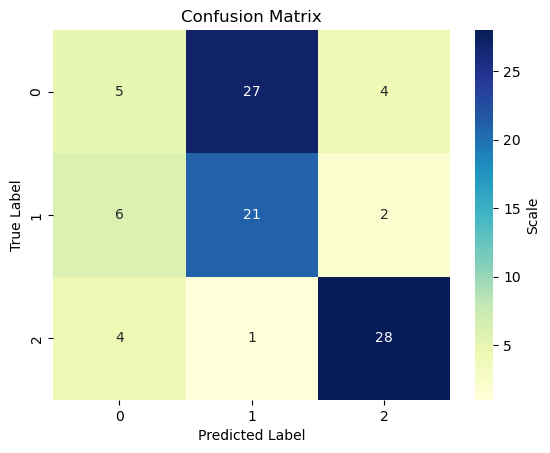

In [56]:
print(model.eval())
targets, predictions= test_model()
confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes)

## Confusion Matrix
matrix = confmat(predictions, targets)
plt.title('Confusion Matrix')
ax = sn.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
ax.set(ylabel="True Label", xlabel="Predicted Label")
matrix = torch.Tensor.numpy(matrix)


## Report of classification
report = classification_report(targets,predictions)
print(report)

## mathews correlation 
mathew = matthews_corrcoef(targets,predictions)

print(mathew)

Confidence Evaluation

In [57]:

from turtle import color

## Get the trick name and the max value confidence from a specific trick
def get_trick_confidence(number):
    load_trick = trickdataset[number][0].view(1,120,1)
    out = loaded_model(load_trick)
    _, prediction = torch.max(out,1)
    sm = nn.Softmax(dim=1)
    conf_numbers = sm(out).detach().numpy()
    conf_numbers = conf_numbers[0]
    conf_number = sm(out).max().detach().numpy()
    trick_confidence = [trick_list[prediction],conf_number,conf_numbers[0],conf_numbers[1],conf_numbers[2],conf_numbers[3],conf_numbers[4]]
    return trick_confidence


list_of_confidences = pd.DataFrame()

real_trick = []
labeled_trick = []
confidence = []
Ollie_confidence = []
fs_180 = []
bs_180 = []
kickflip = []
kickflip_360 = []
for number, trick in enumerate(trickdataset):
    df_trick = get_trick_confidence(number)
    confidence.append(df_trick[1])
    labeled_trick.append(df_trick[0])
    Ollie_confidence.append(df_trick[2])
    fs_180.append(df_trick[3])
    bs_180.append(df_trick[4])
    kickflip.append(df_trick[6])
    kickflip_360.append(df_trick[5])


list_of_confidences = [labeled_trick,confidence]

## Dataset of the confidence of each trick 
df_confidence = pd.DataFrame(
    {
        'Trick':labeled_trick,
        'Confidence_max':confidence,
        'Confidence_ollie':Ollie_confidence,
        'Confidence_fs_180':fs_180,
        'Confidence_bs_180':bs_180,
        'Confidence_kickflip_360':kickflip_360,
        'Confidence_kickflip':kickflip
        
    }
)


df_max_confidence = df_confidence.iloc[:,:2]

df_max_confidence_trick = pd.DataFrame(df_max_confidence.groupby(['Trick']).mean())

## Mean Confidence Value Plot
df_max_confidence.groupby(['Trick']).mean().plot(c='r')
plt.title('Mean Confidence Value')
plt.show()


## Confidence value of each Trick
plt.scatter('Trick','Confidence_max',data=df_max_confidence,color='red')
plt.title('Confidence value of each Trick')
plt.show()


RuntimeError: shape '[1, 120, 1]' is invalid for input of size 303

Correlation Matrix of Model Confidence of Each Trick Type

In [ ]:

## Correlation matrix of the model confidence on the different tricks
corr_matrix = sn.heatmap((df_confidence[df_confidence.columns[1:]]).corr(), vmin=-1, vmax=1, annot=True)
print(corr_matrix)

### Loading exported model and predicting trick

In [ ]:
trick_nr = 99
load_trick = trickdataset[trick_nr][0].view(1,120,9)
out_1 = loaded_model(load_trick)
_, prediction = torch.max(out_1, 1)
sm = nn.Softmax(dim=1) 
print(f'Trick: {trick_list[prediction]}, Confidence: {(sm(out_1).max()*100):.2f}%, Actual: {trick_list[trickdataset[trick_nr][1]]}')
